# Presentation Notebook CFS Capital
Thursday September 20th <br>
<br>
    Eric Brea Garcia
    <br>
    Diederik Ketellapper
    <br>
    Viktor Malesevic
    <br>
    Daniel Wientjens

#### Description

The goal of the project is to predict whether the bitcoin price is going up or down. For this project we use data from the 1st of May 2017 untill the first of May 2018.

We use a variety of sources of information each on a **daily level**:
1. All the reddit comments that reference 'bitcoin' for this timeperiod utilizing google bigquery
2. Forum Data from bis
3. Google Trends data where we retrieve the bitcoin buy/ bitcoin sell +bitcoin buy fraction
4. Tweets by the 100 biggest bitcoin influencers of this time period
5. Bitcoin actual data from poloniex

After this exercise we need to combine the data together to form a master table and then divide this into: Train,Validation and Test.

As a penultimate step we use H2O automl to train a variety of models and use an ensemble to train and predict.

Then finally we report on our data, what the return of our strategy would be for March and April of 2018.

_Please note that not all code of this notebook runs, and it should not be used as such because of the long datadownloads, but it is intended to give a short concise overview of our project and the results. The full code can be found: https://github.com/ViktorMalesevic/Bitcoin-NLP-Strategy _




# 1. Reddit Comments

We downloaded all the reddit comments in the given time period and afterwards performed sentimed analysis and grouped by day

We used google cloud for the processing power to download all the reddit comments referencing bitcoin within the time period as below

#standardSQL
SELECT created_utc, body

FROM(
  SELECT
    *
  FROM
    `fh-bigquery.reddit_comments.2017_05` UNION ALL
  SELECT
    *
  FROM
    `fh-bigquery.reddit_comments.2017_06` UNION ALL
  SELECT
    *
  FROM
    `fh-bigquery.reddit_comments.2017_07` UNION ALL
  SELECT
    *
  FROM
    `fh-bigquery.reddit_comments.2017_08` UNION ALL
  SELECT
    *
  FROM
    `fh-bigquery.reddit_comments.2017_09` UNION ALL
  SELECT
    *
  FROM
    `fh-bigquery.reddit_comments.2017_10` UNION ALL
  SELECT
    *
  FROM
    `fh-bigquery.reddit_comments.2017_11` UNION ALL
  SELECT
    *
  FROM
    `fh-bigquery.reddit_comments.2017_12` UNION ALL
  SELECT
    *
  FROM
    `fh-bigquery.reddit_comments.2018_01` UNION ALL
  SELECT
    *
  FROM
    `fh-bigquery.reddit_comments.2018_02` UNION ALL
  SELECT
    *
  FROM
    `fh-bigquery.reddit_comments.2018_03` UNION ALL
  SELECT
    *
  FROM
    `fh-bigquery.reddit_comments.2018_04`) 
    
WHERE REGEXP_CONTAINS(body, r'bitcoin')

In [5]:
import pandas as pd
import re
from datetime import datetime
import re

In [2]:
# download the reddit comments
reddit = pd.read_csv("/Users/Mobile/Downloads/r_comments")

In [ ]:
# define a cleaning function for the reddit comments
def clean(body):
 return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", body).split())

In [ ]:
# clean the reddit comments and dates
reddit['body'] = reddit.body.apply(clean)
reddit['date'] = reddit.created_utc.apply(datetime.fromtimestamp)
reddit['date'] = reddit.date.dt.date

In [ ]:
# Here we perform the sentiment analysis it already computes the magnitude times the sentiment

# Import the module
from textblob import TextBlob
def analize_sentiment(comment):
    analysis = TextBlob(comment)
    return(analysis.sentiment.polarity)

reddit['SA'] = np.array([ analize_sentiment(comment) for comment in reddit['body']])

Here we have to group the data by day and we do that by looking at the count of comments and the average sentiment analysis. 

In [ ]:
# group by date
reddit_groupby= reddit.groupby('date').agg({'body':'count', 'SA':'mean'})

In [ ]:
reddit_groupby = reddit_groupby.rename(columns={'body':'count_comments', 'SA':'mean_sa'}).reset_index()

In [ ]:
reddit_groupby.to_csv("Data/allreddit_nlp.csv")

# 2 Forum Data

 The forum data is a similiar exercise to the reddit comments and is here ommited for brevity 

# 3 Google Trends Data 

Here we download data from Google trends and carry out some of the pre-processing related to it. What we look at is the ratio of "buy bitcoin" versus the sum of "buy bitcoin" & "sell bitcoin" to get a feeling about how the trend is evolving over time. This solves as well one of our problems as google does not output the raw nummer of searches but gives you a number representing the change in your time period. Multiple downloads over multiple timeperiods cannot be compared as it seems that google adds some noise as well. 
This fraction is a solution but we do not assume it is the most optimal one.

In [ ]:
# necessary imports
from pytrends.request import TrendReq

In [ ]:
# Get the relevant timeframes to search on
timeframes2017 = list()
timeframesmix = list()
timeframes2018 = list()
for i in range(5,11):
    timeframes2017.append('2017-'+str(i)+'-1 2017-'+str(i+2)+'-1')
timeframesmix.append('2017-'+'11'+'-1 2018-'+'1'+'-1')
timeframesmix.append('2017-'+'12'+'-1 2018-'+'2'+'-1')
for i in range(1,5):
    timeframes2018.append('2018-'+str(i)+'-1 2018-'+str(i+2)+'-1')
timeframes = timeframes2017+timeframesmix+timeframes2018

In [ ]:
# download using pytrends the referenced timeperiods
pytrend = TrendReq(hl='en-US', tz=360)
list_google = list()
for timeframe in timeframes:
    pytrend.build_payload(kw_list=['Buy Bitcoin', 'Sell Bitcoin'], 
                      timeframe=timeframe)
    list_google.append(pytrend.interest_over_time())

In [ ]:
# append all the dataframes to one large one
df = pd.DataFrame(list_google[0])

for i in range(1,11):
    df = df.append(list_google[i])

In [ ]:
# Calculate the fraction
df['googletrends_buy_sell'] = df["Buy Bitcoin"]/(df["Sell Bitcoin"]+df["Buy Bitcoin"])
df = df[['googletrends_buy_sell']] 

In [ ]:
# take the mean for the overlapping dates and output the data
df = df.groupby('date').mean().reset_index()
df.to_csv("Data/google_trends.csv")

# 4 Downloading the Twitter Dataset of the 100 biggest influencers

Here we are going to webscrap the twitter accounts of the top-100 influencers in the cryptocurrency world, according to cryptoweekly ("https://cryptoweekly.co/100/").

The first step is to webscrape the twitter account names from cryptoweekly:

In [3]:
from urllib.request import urlopen
from bs4 import BeautifulSoup as soup

def getTwitterHandles():
    # Fill in with url of page which is to be scraped
    url = "https://cryptoweekly.co/100/"

# Retreives and parses page html
    client = urlopen(url)
    pageHtml = client.read()
    pageSoup = soup(pageHtml, "html.parser")

# Adds all Twitter handles to twitterHandles list
    profiles = pageSoup.findAll("div", {"class":"testimonial-wrapper"})
    twitterHandles = []
    for person in profiles:
        twitterHandles.append(person.findAll("div",{"class":"author"}))
    for i in range(len(twitterHandles)):
        twitterHandles[i]=twitterHandles[i][0].findAll("a")[0].text[1:]

    client.close()
    return twitterHandles

Below we download the tweets. Because of the large download (it takes ~1h) please consider carefully to run

In [ ]:
import tweepy
import csv
import sys

# Twitter API credentials (expired, don't even try it)
consumer_key = ""
consumer_secret = ""
access_key = ""
access_secret = ""


def get_all_tweets(screen_name):
	print("Getting tweets from @" + str(screen_name))

	#Twitter only allows access to a users most recent 3240 tweets with this method
	
	#authorize twitter, initialize tweepy
	auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
	auth.set_access_token(access_key, access_secret)
	api = tweepy.API(auth)
	
	#initialize a list to hold all the tweepy Tweets
	alltweets = []	
	
	#make initial request for most recent tweets (200 is the maximum allowed count)
	new_tweets = api.user_timeline(screen_name = screen_name,count=200)
	
	#save most recent tweets
	alltweets.extend(new_tweets)
	
	#save the id of the oldest tweet less one
	oldest = alltweets[-1].id - 1
	
	#keep grabbing tweets until there are no tweets left to grab
	while len(new_tweets) > 0:
		print ("Getting tweets before %s" % (oldest))
		
		#all subsiquent requests use the max_id param to prevent duplicates
		new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
		
		#save most recent tweets
		alltweets.extend(new_tweets)
		
		#update the id of the oldest tweet less one
		oldest = alltweets[-1].id - 1
		
		print ("...%s tweets downloaded so far" % (len(alltweets)))

	#transform the tweepy tweets into a 2D array that will populate the csv	
	outtweets = [[tweet.id_str.encode('utf-8'), tweet.created_at.strftime('%m/%d/%Y'), tweet.text.encode('utf-8')] for tweet in alltweets]
	
	#write the csv	
	with open('Data/Tweets/%s_tweets.csv' % screen_name, 'w') as f:
		writer = csv.writer(f)
		writer.writerow(["id","created_at","text"])
		writer.writerows(outtweets)
	
	pass


if __name__ == '__main__':
	handles = getTwitterHandles()
    # The Peter Todd twitter handle is updated to his new account, as long as the old one was listed in the website:
	for i in range(len(handles)):
		if handles[i] == 'petertoddbtc':
			handles[i] = 'peterktodd'
	for handle in handles:
		get_all_tweets(str(handle))

After downloading the tweets we do a similar exercise as with the reddit comments.
We also remove any tweets that are not in the correct timeframe. This is ommited for brevity.

# 5 Importing the poloniex data 

## Step 1. Importing from Poloniex
Poloniex is a cryptocurrency exchange found on https://poloniex.com/exchange, to download the data we use a package made by a poloniex community member.

In [6]:
import poloniex
import datetime

Importing from API

To import poloniex we need to install the package in the console using:
pip install poloniex

The help function gives a list of functions included in the package and some descriptions
help(poloniex.poloniex)

We are using the public data so no keys are needed

The package has many functionalities but the information we want is public, therefore we do not need access tokens or secret keys. The currency we are looking for is BitCoin relative to the USD, therefore looking at the documentation we know that we need to search using the term 'USDT_BTC', with an additional parameter of seconds between measurements. We chose to take the 24 hours frequency.

In [8]:
polo = poloniex.Poloniex()
btc86400 = pd.DataFrame(polo.returnChartData("USDT_BTC", 86400))

## Step 2. Pre-processing


In [9]:
#Transform the unix timestamp to datetime:
btc86400.date = pd.to_datetime(btc86400.date, unit = 's')
#Setting the date as index:
btc86400.set_index('date', inplace = True)
#Taking the period 2017-05-01 to 2018-05-02 (one more day for lagged purposes):
btc_data = btc86400["2017-04-16":"2018-05-02"]
#We decide to take only close and volume since the other columns are extremly correlated to these and may not provide more useful information for our purpose.
returns_data = btc_data[["close"]]
#Now let's look at the returns (indeed, the close price itself is not particularly interesting):
returns_data = returns_data.pct_change()
volatility_data = returns_data.rolling(14).std()
#We are going to add the volatility of the last 14 days:
volatility_data = volatility_data.rename(columns = {'close': 'volatility_14'})

In [10]:
# final changes for clarity
returns_data = returns_data.shift(-1)
returns_data = returns_data.dropna()
returns_data.columns = ["return_day+1"]

In [ ]:
#Now we put back together the returns at day+1 with the close and volume information from earlier. We also dropna() for deleting the day 2018-05-02.
data = pd.concat((returns_data, btc_data[["close","volume"]]), axis = 1)
data = pd.concat((data, volatility_data), axis = 1)
data = data.dropna()
# filter
data = data["may-2017":"may-2018"]
data.to_csv("Data/poloniex_data.csv")
#Creating a csv file for later purposes and checking that reading it works.

# 6. Combining data

# RUN FROM HERE

In [18]:
import pandas as pd
import numpy as np

In [19]:
# Load CSV files:
poloniex = pd.read_csv("Data/poloniex_data.csv")
ggtrends = pd.read_csv("Data/google_trends.csv")
twitter = pd.read_csv("Data/twitter_agg_ddb.csv")
reddit = pd.read_csv("Data/allreddit_nlp.csv")
forum = pd.read_csv("Data/merit_compound.csv")

In [20]:
# A bit of preprocessing:
# GOOGLE TRENDS:
ggtrends = ggtrends.loc[:, ~ggtrends.columns.str.contains('^Unnamed')]
# REDDIT:
reddit = reddit.loc[:, ~reddit.columns.str.contains('^Unnamed')]
reddit = reddit.rename(columns={'date_notime': 'date', 'count_comments': 'Reddit Comments (#)', 'mean_sa': 'Reddit Average SA'})
# TWITTER:
twitter = twitter.rename(columns={'created_at': 'date','Average SA': 'Twitter Average SA'})
twitter['date'] =  pd.to_datetime(twitter['date'], format='%Y%m%d %H:%M:%S')
twitter['date'] = twitter['date'].dt.date
twitter['date'] = twitter['date'].apply(str)

# FORUM:
forum = forum.loc[:, ~forum.columns.str.contains('^Unnamed')]
forum = forum.rename(columns={'newdate': 'date', 'compound': 'Forum SA Merit', 'merit_compound': 'Forum SA Merit (weighted)'})

In [21]:
# Merge the datasets into one Master Table:
master = pd.merge(poloniex, ggtrends, how = 'inner', on = 'date')
master = pd.merge(master, twitter, how = 'outer', on = 'date')
master = pd.merge(master, forum, how = 'inner', on = 'date')
master = pd.merge(master, reddit, how = 'inner', on = 'date')

In [22]:
# Create the UP/DOWN class:
master['invest'] = master['return_day+1']>0

# 7. MODEL DEVELOPMENT

In [23]:
from sklearn import preprocessing
import h2o
from h2o.automl import H2OAutoML

We scale the data before giving it to the model:

In [24]:
data = pd.read_csv("Data/20180920_mastertable.csv")
invest = data.invest
date = data.date
data = data.dropna()
data_scaled = data.drop(["date","Unnamed: 0","return_day+1","invest"], axis=1)
cols = data_scaled.columns
data_scaled = preprocessing.scale(data_scaled)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = cols
data_scaled["invest"] = invest
data_scaled["date"] = date
data = data_scaled
data.head(5)

,close,volume,volatility_14,googletrends_buy_sell,Tweets (#),Active Influencers (#),Twitter Average SA,Forum SA Merit,Forum SA Merit (weighted),Reddit Comments (#),Reddit Average SA,invest,date
0,-1.259410,-0.885228,-1.815638,-0.617938,-1.229630,-1.308931,2.019758,-0.730275,1.544647,-0.857860,1.610330,True,2017-05-01
1,-1.246628,-0.809811,-1.826866,1.350456,-1.368504,-0.838780,4.091047,-0.024282,1.840794,-0.987301,1.935256,True,2017-05-02
2,-1.249417,-0.566294,-1.803027,-0.836648,-1.185774,-1.120870,1.869204,0.397697,2.109174,-0.770868,0.690981,False,2017-05-03
3,-1.263814,-0.435161,-1.564961,-1.602135,-1.448905,-1.026840,0.465855,0.413071,1.449825,-0.811220,0.253766,False,2017-05-04
4,-1.250772,-0.672864,-1.518604,0.326891,-1.602398,-1.967142,-0.707008,-1.211215,1.046577,-0.925463,-0.907606,True,2017-05-05


Now we initialize the H2O API, which will run different models and compare them

In [25]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.151-b12, mixed mode)


C:\Users\Eric\Anaconda3\lib\site-packages\h2o\backend\server.py:332: UserWarning:   You have a 32-bit version of Java. H2O works best with 64-bit Java.
  Please download the latest 64-bit Java SE JDK from Oracle.

  warn("  You have a 32-bit version of Java. H2O works best with 64-bit Java.\n"


  Starting server from C:\Users\Eric\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Eric\AppData\Local\Temp\tmpguo_ycy0
  JVM stdout: C:\Users\Eric\AppData\Local\Temp\tmpguo_ycy0\h2o_Eric_started_from_python.out
  JVM stderr: C:\Users\Eric\AppData\Local\Temp\tmpguo_ycy0\h2o_Eric_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Europe/Paris
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.7
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_Eric_0mmguf
H2O cluster total nodes:,1
H2O cluster free memory:,247.5 Mb
H2O cluster total cores:,0
H2O cluster allowed cores:,0
H2O cluster status:,"accepting new members, healthy"


We separate the data in train, validation and test; as 60-20-20.

In [26]:
train = data[0:218]
validation = data[219:291]
test = data[292:]
#train["invest"] = asfactor(train["invest"])
#test["invest"] = asfactor(test["invest"])
train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)
validation = h2o.H2OFrame(validation)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


We assign the value to predict:

In [27]:
x = train.columns
y = "invest"
x.remove(y)


We run AutoML for 30 seconds:

In [28]:
aml = H2OAutoML(max_runtime_secs = 30)
aml.train(x = x, y = y,
          training_frame = train,
          validation_frame = validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb
#h2o.shutdown(prompt=False)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GLM_grid_0_AutoML_20180920_194033_model_0,0.664236,0.639542,0.465625,0.475377,0.225984
StackedEnsemble_BestOfFamily_0_AutoML_20180920_194033,0.644444,0.648076,0.467274,0.478142,0.22862
GBM_grid_0_AutoML_20180920_194033_model_2,0.616493,0.692409,0.438455,0.494513,0.244543
GBM_grid_0_AutoML_20180920_194033_model_1,0.596354,0.70799,0.456771,0.500512,0.250513
GBM_grid_0_AutoML_20180920_194033_model_3,0.594965,0.711176,0.5,0.501973,0.251977
DeepLearning_grid_0_AutoML_20180920_194033_model_1,0.589931,0.729725,0.5,0.507422,0.257477
GBM_grid_0_AutoML_20180920_194033_model_0,0.583767,0.746501,0.494444,0.511981,0.262125
XRT_0_AutoML_20180920_194033,0.575998,0.860098,0.5,0.506134,0.256171
DeepLearning_0_AutoML_20180920_194033,0.563976,0.733064,0.465625,0.512571,0.262729
DRF_0_AutoML_20180920_194033,0.561328,0.725252,0.492795,0.509667,0.25976


And we save the best model (based on AUC), which happened to be a GLM obtaining a AUC=0.66:

In [29]:
model_path = h2o.save_model(model=aml.leader, path = "nonlagged_leadermodel_GLM", force = True)

Create predictions using this model, and save them to a .csv file:

In [30]:
preds = aml.leader.predict(test)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [31]:
predictions = preds.as_data_frame()
predictions

,predict,False,True
0,True,0.175136,0.824864
1,True,0.062958,0.937042
2,True,0.145614,0.854386
3,True,0.323121,0.676879
4,True,0.338793,0.661207
...,...,...,...
67,True,0.349115,0.650885
68,False,0.433633,0.566367
69,True,0.359369,0.640631
70,False,0.495186,0.504814


In [32]:
predictions.to_csv('Data/nonlagged_predictions.csv')

# 8. BACKTESTING THE INVESTMENT STRATEGY

Here we will compare the performance of a buy/sell strategy according to the predictions of opur model versus a simple buy and hold strategy.

In [33]:
import matplotlib as mpl
#mpl.
%matplotlib inline

pd.set_option('display.max_rows', 10)

We are going to backtest the strategy in the validation set, after some prerpocessing the data is the following:

In [34]:
data = pd.read_csv("Data/backtest_data.csv")
data

,date,close,predict,False,True
0,2018-02-17,11049.000000,True,0.175136,0.824864
1,2018-02-18,10379.000000,True,0.062958,0.937042
2,2018-02-19,11156.000000,True,0.145614,0.854386
3,2018-02-20,11217.165085,True,0.323121,0.676879
4,2018-02-21,10441.060500,True,0.338793,0.661207
...,...,...,...,...,...
67,2018-04-25,8860.024074,True,0.349115,0.650885
68,2018-04-26,9286.000000,False,0.433633,0.566367
69,2018-04-27,8920.010000,True,0.359369,0.640631
70,2018-04-28,9330.761257,False,0.495186,0.504814


And then we set the first closing price to a 100 and all the rest with respect to that:

In [35]:
btc_price = data[["close","predict"]]
btc_price["close"] = btc_price["close"].rebase(100)
btc_price

C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,close,predict
0,100.000000,True
1,93.936103,True
2,100.968413,True
3,101.521994,True
4,94.497787,True
...,...,...
67,80.188470,True
68,84.043805,False
69,80.731378,True
70,84.448921,False


In [ ]:
And we implement the strategy based on the bitcoin

In [36]:
btc_returns = btc_price.copy()
btc_returns["returns"] = btc_returns["close"].pct_change()
btc_returns["returns"] = btc_returns["returns"] #.shift(-1)
#btc_returns["strategy"] = btc_returns["close"]
#btc_returns["strategy"].loc[data[["predict"]] == False, btc_returns["strategy"]] = 0
btc_returns["strategy_returns"] = btc_returns["returns"]
btc_returns.loc[btc_returns["predict"] == False, "strategy_returns"] = 0

In [37]:
btc_returns["strategy_close"] = btc_returns["close"]
btc_returns["strategy_close"] = 100 * np.cumprod(btc_returns["strategy_returns"] + 1)

In [38]:
btc_returns

,close,predict,returns,strategy_returns,strategy_close
0,100.000000,True,NaN,NaN,NaN
1,93.936103,True,-0.060639,-0.060639,93.936103
2,100.968413,True,0.074863,0.074863,100.968413
3,101.521994,True,0.005483,0.005483,101.521994
4,94.497787,True,-0.069189,-0.069189,94.497787
...,...,...,...,...,...
67,80.188470,True,-0.080303,-0.080303,91.236169
68,84.043805,False,0.048078,0.000000,91.236169
69,80.731378,True,-0.039413,-0.039413,87.640269
70,84.448921,False,0.046048,0.000000,87.640269


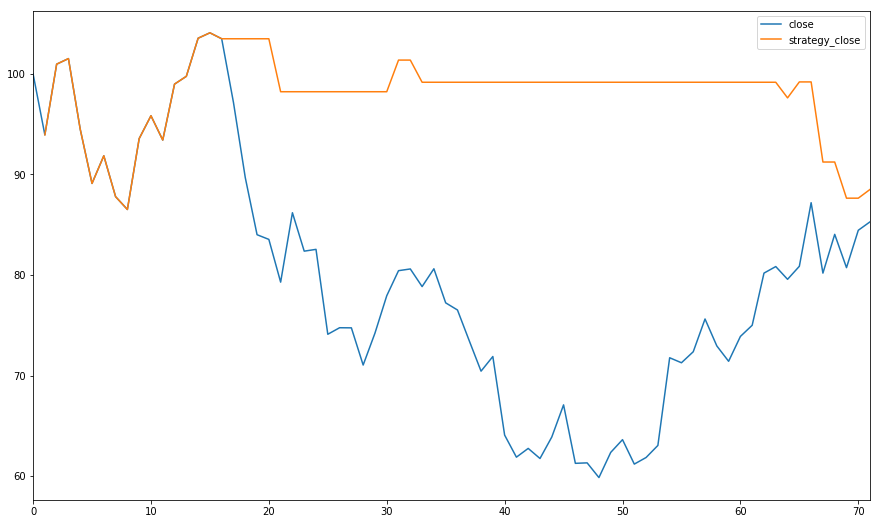

In [39]:
btc_returns[["close","strategy_close"]].plot(figsize = (15,9))